# Introduction

### Exploratory data analysis

In [325]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif

np.random.seed(0)
%matplotlib inline

In [326]:
# read data
X = pd.read_csv('data/TCGAdata.txt', delim_whitespace=True, index_col=0, header=0)
Y = pd.read_csv('data/TCGAlabels.txt', delim_whitespace=True, index_col=0, header=0)

# merge to have the dataset in one dataframe
data = pd.concat([X, Y], axis=1)

Y['x'].unique()
# assign a numbered label for Y
label_map = {'GBM': 0, 'BC': 1, 'OV': 2, 'LU': 3, 'KI': 4, 'U': 5}
Y['x'] = Y['x'].map(label_map)

<AxesSubplot: xlabel='x', ylabel='count'>

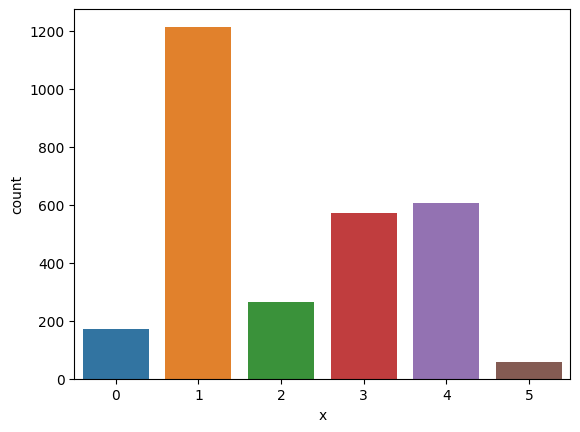

In [327]:
# hist of the class labels
sns.countplot(data=Y, x='x')

### Split dataset, define classifiers, folds and general methods

In [328]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

n_PCs = [500, 100, 50, 40, 35, 30, 25, 10]
n_top_features = [250, 225, 200, 175, 150, 100, 75, 50, 40, 35, 30]
n_neighbors = [1, 2, 3, 5, 8, 10, 50, 100, 300]

stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn = KNeighborsClassifier(weights='uniform')
logistic = LogisticRegression(class_weight='balanced', C=1e-10, random_state=42)
rf = RandomForestClassifier(n_estimators=50,  class_weight='balanced', random_state=42)
mlp = MLPClassifier(random_state=42, hidden_layer_sizes=(50, 50))
dummy = DummyClassifier(strategy='most_frequent')

In [329]:
def apply_mislabeling(Y_train, percentage):
    num_samples = Y_train.shape[0]
    num_mislabeled_samples = int(num_samples * percentage)
    mislabeled_indices = np.random.choice(num_samples, num_mislabeled_samples, replace=False)
    for idx in mislabeled_indices:
        original_label = Y_train.iloc[idx]
        # ensure that the new label is different from the original one
        replacement_choices = np.setdiff1d([0, 1, 2, 3, 4, 5], [original_label])
        new_label = np.random.choice(replacement_choices)
        Y_train.iloc[idx] = new_label
        
    return Y_train

In [330]:
def splits(gaussian_noise_factor=0, mislabel_percentage=0, test_size=0.2):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42, stratify=Y)
    
    noise = np.random.normal(0, 1, Y_train.shape)
    X_train_noisy = X_train + gaussian_noise_factor * noise
    Y_train_mislabeled = apply_mislabeling(Y_train.copy(), mislabel_percentage)

    return X_train_noisy, X_test, Y_train_mislabeled, Y_test

X_train, X_test, Y_train, Y_test = splits()

### Assume optimal number of PC

Number of components needed to explain 80% variance: 214
Number of components needed to explain 50% variance: 15


<AxesSubplot: >

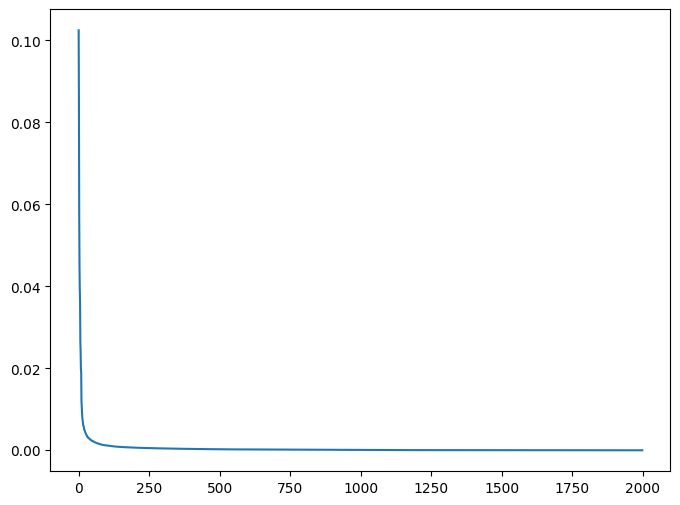

In [331]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=2000)  
principal_components = pca.fit_transform(X_scaled)

explained_variance_ratios = pca.explained_variance_ratio_
cumulative_variance_ratios = np.cumsum(pca.explained_variance_ratio_)

n_components_80 = len(cumulative_variance_ratios[cumulative_variance_ratios <= 0.8]) + 1
print(f"Number of components needed to explain 80% variance: {n_components_80}")
n_components_50 = len(cumulative_variance_ratios[cumulative_variance_ratios <= 0.5]) + 1
print(f"Number of components needed to explain 50% variance: {n_components_50}")

plt.figure(figsize=(8, 6))
sns.lineplot(data=pca.explained_variance_ratio_)

# Setup

### Part 1 - task 1

In [332]:
# setup and function for part 1 - task 1
parameters_1 = {
    'pca__n_components': n_PCs,
    'estimator__n_neighbors': n_neighbors
}

pipeline_1 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('estimator', knn)
])

def grid_search_1(X_train, Y_train):
    grid_search = GridSearchCV(pipeline_1, parameters_1, cv=stratified_k_fold, scoring='balanced_accuracy', n_jobs=-1)
    grid_search.fit(X_train, np.ravel(Y_train))
    print(grid_search.best_params_)
    print(grid_search.best_score_)    
    
    return grid_search

def classification_report_1(X_test, Y_test, grid_search_1):
    Y_test_pred_1 = grid_search_1.predict(X_test)
    best_params_1 = grid_search_1.best_params_
    print("Classification Report \nOptimal parameters - ",
        best_params_1['estimator__n_neighbors'], " neighbors and ",
        best_params_1['pca__n_components'], "principal components:\n\n",
        classification_report_1(Y_test, Y_test_pred_1))

In [333]:
def plot_accuracy_vs_nr_neighbors_1(grid_search_1):
    cv_results = grid_search_1.cv_results_
    params = cv_results['params']
    mean_test_scores = cv_results['mean_test_score']
    
    neighbors = [params[i]['estimator__n_neighbors'] for i in range(len(params))]
    components = [params[i]['pca__n_components'] for i in range(len(params))]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(neighbors, mean_test_scores, c=components, cmap='viridis', alpha=0.8)
    plt.colorbar(label='Number of PCA Components')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Neighbors with PCA Components')
    plt.grid(True)
    plt.show()

def plot_accuracy_vs_nr_pcs_1(grid_search_1):
    cv_results = grid_search_1.cv_results_
    params = cv_results['params']
    mean_test_scores = cv_results['mean_test_score']
    
    neighbors = [params[i]['estimator__n_neighbors'] for i in range(len(params))]
    components = [params[i]['pca__n_components'] for i in range(len(params))]

    plt.figure(figsize=(10, 6))
    plt.scatter(components, mean_test_scores, c=neighbors, cmap='viridis', alpha=0.8)
    plt.colorbar(label='Number of Neighbors')
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of PCA Components with Number of Neighbors')
    plt.grid(True)
    plt.show()

### Part 1 - task 2

In [334]:
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif


parameters_2 = {
    'kbest__k': n_top_features,
    'estimator__n_neighbors': n_neighbors
}

pipeline_2 = Pipeline([
    ('th', VarianceThreshold()),
    ('scaler', StandardScaler()),
    ('kbest', SelectKBest(score_func=f_classif)),
    ('estimator', knn)
])

def grid_search_2(X_train, Y_train):
    grid_search = GridSearchCV(pipeline_2, parameters_2, cv=stratified_k_fold, scoring='balanced_accuracy', n_jobs=-1)
    grid_search.fit(X_train, np.ravel(Y_train))
    print(grid_search.best_params_)
    print(grid_search.best_score_)    
    
    return grid_search

def classification_report_2(X_test, Y_test, grid_search_2):
    Y_test_pred_2 = grid_search_2.predict(X_test)
    best_params_2 = grid_search_2.best_params_
    print("Classification Report \nOptimal parameters - ",
        best_params_2['estimator__n_neighbors'], " neighbors and ",
        best_params_2['kbest__k'], "top features:\n\n",
        classification_report_1(Y_test, Y_test_pred_2))

In [335]:
def plot_accuracy_vs_nr_neighbors_2(grid_search_2):
    cv_results = grid_search_2.cv_results_
    params = cv_results['params']
    mean_test_scores = cv_results['mean_test_score']
    
    neighbors = [params[i]['estimator__n_neighbors'] for i in range(len(params))]
    features = [params[i]['kbest__k'] for i in range(len(params))]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(neighbors, mean_test_scores, c=features, cmap='viridis', alpha=0.8)
    plt.colorbar(label='Number of Features')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Neighbors with Features')
    plt.grid(True)
    plt.show()

def plot_accuracy_vs_nr_features_2(grid_search_2):
    cv_results = grid_search_2.cv_results_
    params = cv_results['params']
    mean_test_scores = cv_results['mean_test_score']
    
    neighbors = [params[i]['estimator__n_neighbors'] for i in range(len(params))]
    features = [params[i]['kbest__k'] for i in range(len(params))]

    plt.figure(figsize=(10, 6))
    plt.scatter(features, mean_test_scores, c=neighbors, cmap='viridis', alpha=0.8)
    plt.colorbar(label='Number of Neighbors')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Features with Number of Neighbors')
    plt.grid(True)
    plt.show()

# Training

### Get scores and predictions

In [336]:
from sklearn.metrics import balanced_accuracy_score, classification_report

def train_test(X_train, Y_train, X_test, Y_test, model=None, parameters=None):
    pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('classifier', dummy)])
    if model is not None:
        pipeline.set_params(classifier=model)
             
    if parameters is not None:
        pipeline.set_params(**parameters)
        
    pipeline.fit(X_train, np.ravel(Y_train))
    Y_test_pred = pipeline.predict(X_test)
    Y_train_pred = pipeline.predict(X_train)
    train_score = balanced_accuracy_score(Y_train, Y_train_pred)
    test_score = balanced_accuracy_score(Y_test, Y_test_pred)
    # print('Parameters: ', parameters)
    # print('Train accuracy score: ', train_score)
    # print('Test accuracy score: ', test_score)

    return pipeline.named_steps['classifier'], train_score, test_score, Y_train_pred, Y_test_pred

### KNN for various parameters

In [337]:
def train_test_knn(X_train, Y_train, X_test, Y_test):

    best_score = 0
    best_k = 0

    for k in n_neighbors:
        _, train_score, _, _, _ = train_test(X_train, Y_train, X_test, Y_test, model=knn, parameters={'classifier__n_neighbors': k})
        if  train_score > best_score:
            best_score = train_score
            best_k = k
        
    print('Best training k:', best_k)
    print('Best training score:', best_score)

In [338]:
train_test_knn(X_train, Y_train, X_test, Y_test)

Best training k: 1
Best training score: 1.0


# Part 1

In [339]:
X_train, X_test, Y_train, Y_test = splits()

### Part 1 - task 1: number of PC that optimize predictive performance

In [340]:
grid_search_1 = grid_search_1(X_train, Y_train)

ValueError: Invalid parameter 'n_components' for estimator KNeighborsClassifier(n_neighbors=300). Valid parameters are: ['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'].

In [ ]:
plot_accuracy_vs_nr_neighbors_1(grid_search_1)

KeyError: 'knn__n_neighbors'

Classification Report 
Optimal parameters -  1  neighbors and  40 principal components:

               precision    recall  f1-score   support

          BC       1.00      1.00      1.00       243
         GBM       1.00      1.00      1.00        35
          KI       0.99      0.99      0.99       121
          LU       0.98      0.99      0.99       114
          OV       1.00      0.96      0.98        53
           U       0.85      0.92      0.88        12

    accuracy                           0.99       578
   macro avg       0.97      0.98      0.97       578
weighted avg       0.99      0.99      0.99       578



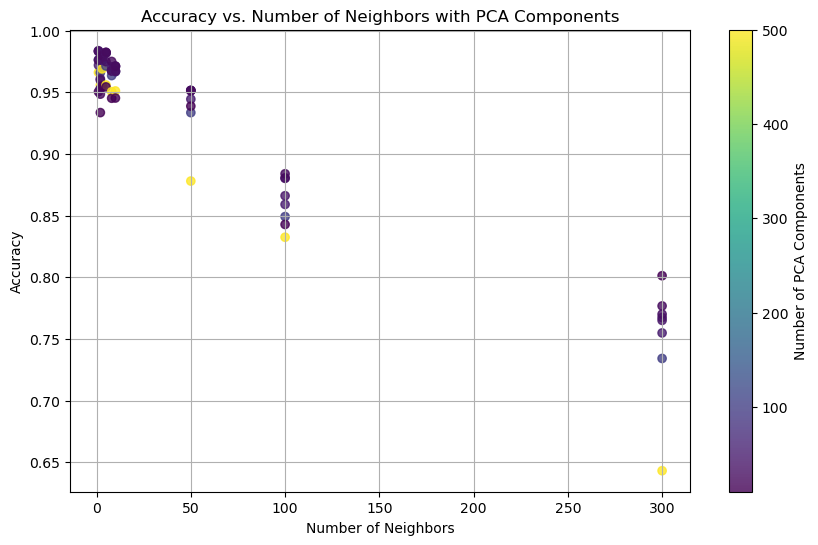

In [ ]:
plot_accuracy_vs_nr_pcs_1(grid_search_1)

### Part 1 - task 2: number of features that optimize predictive performance

In [ ]:
grid_search_2 = grid_search_2(X_train, Y_train)

In [ ]:
plot_accuracy_vs_nr_neighbors_2(grid_search_2)

Classification Report 
Optimal parameters -  3  neighbors and  200 variables:

               precision    recall  f1-score   support

          BC       0.98      1.00      0.99       243
         GBM       1.00      1.00      1.00        35
          KI       1.00      0.99      1.00       121
          LU       1.00      0.99      1.00       114
          OV       1.00      0.98      0.99        53
           U       0.91      0.83      0.87        12

    accuracy                           0.99       578
   macro avg       0.98      0.97      0.97       578
weighted avg       0.99      0.99      0.99       578



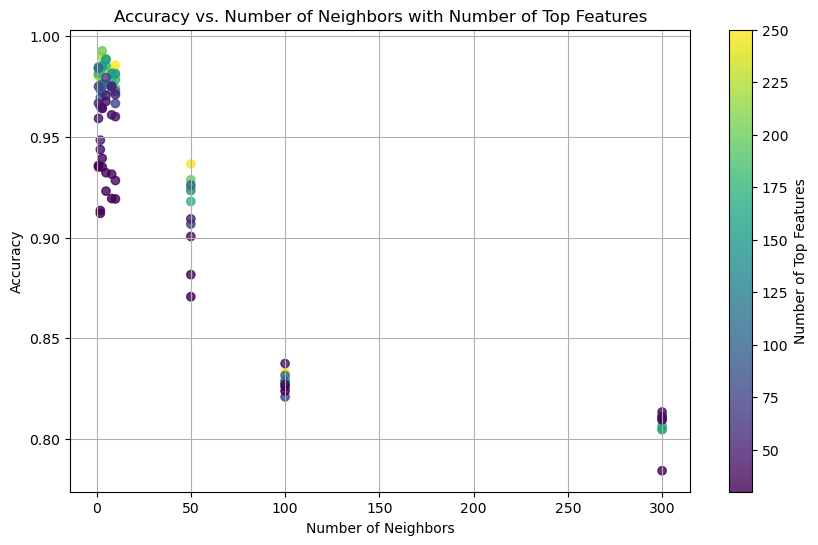

In [ ]:
plot_accuracy_vs_nr_features_2(grid_search_2)

# Part 2

In [ ]:
Y_train = apply_mislabeling(Y_train, percentage=0.2)

In [ ]:
train_test_knn(X_train, Y_train, X_test, Y_test)

UFuncTypeError: ufunc 'greater' did not contain a loop with signature matching types (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.StrDType'>) -> None

<Figure size 1000x800 with 0 Axes>

### Part 2 - task 1: number of PC that optimize predictive performance

### Part 2 - task 2: number of features that optimize predictive performance

In [ ]:
grid_search_2 = grid_search_2(X_train, Y_train)

In [ ]:
plot_accuracy_vs_nr_neighbors_2(grid_search_2)

Classification Report 
Optimal parameters -  3  neighbors and  200 variables:

               precision    recall  f1-score   support

          BC       0.98      1.00      0.99       243
         GBM       1.00      1.00      1.00        35
          KI       1.00      0.99      1.00       121
          LU       1.00      0.99      1.00       114
          OV       1.00      0.98      0.99        53
           U       0.91      0.83      0.87        12

    accuracy                           0.99       578
   macro avg       0.98      0.97      0.97       578
weighted avg       0.99      0.99      0.99       578



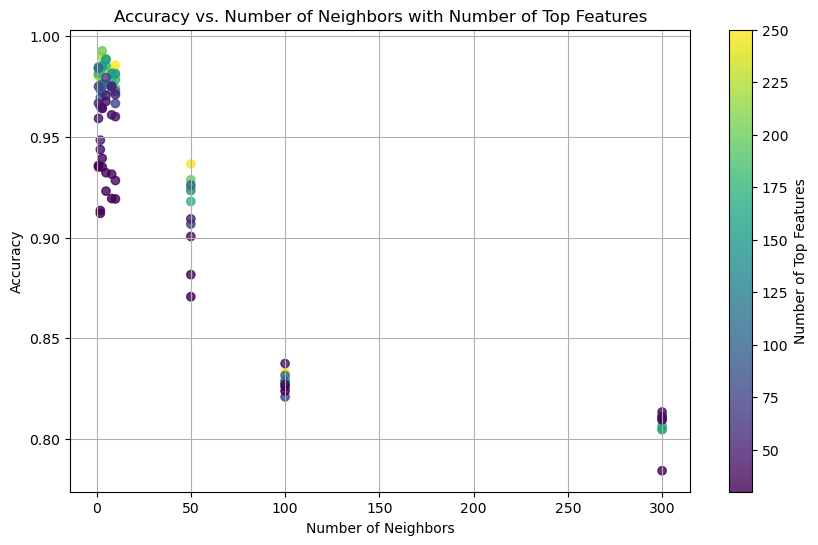

In [ ]:
plot_accuracy_vs_nr_features_2(grid_search_2)

In [ ]:
grid_search_1 = grid_search_1(X_train, Y_train)

In [ ]:
plot_accuracy_vs_nr_neighbors_1(grid_search_1)

KeyError: 'knn__n_neighbors'

Classification Report 
Optimal parameters -  1  neighbors and  40 principal components:

               precision    recall  f1-score   support

          BC       1.00      1.00      1.00       243
         GBM       1.00      1.00      1.00        35
          KI       0.99      0.99      0.99       121
          LU       0.98      0.99      0.99       114
          OV       1.00      0.96      0.98        53
           U       0.85      0.92      0.88        12

    accuracy                           0.99       578
   macro avg       0.97      0.98      0.97       578
weighted avg       0.99      0.99      0.99       578



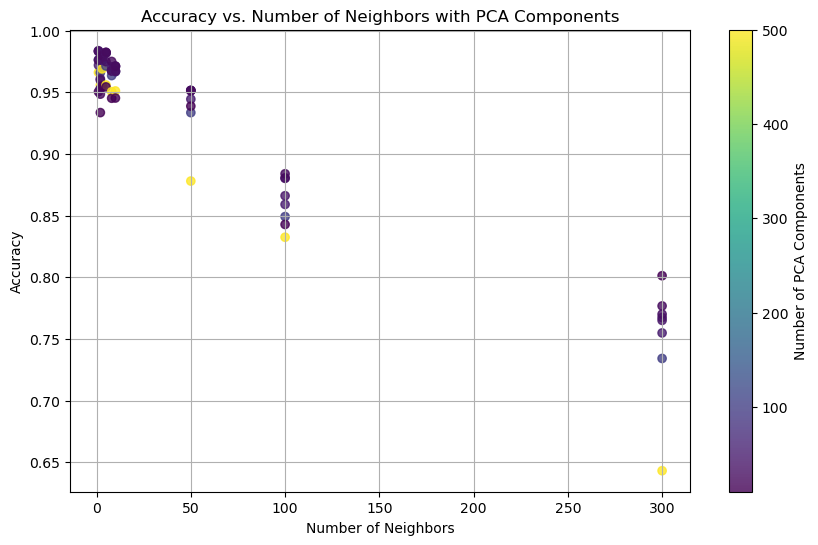

In [ ]:
plot_accuracy_vs_nr_pcs_1(grid_search_1)